# Analysis of aggregated figures

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

import os

from core import *

from config import image_stats_file, figures_dir, latex_dir, xls_file, image_level_results_file, aggregated_results_file
from config import exclude_stare_training, aggregated_threshold

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 10000)

data= pd.read_csv(image_stats_file)
il_results= pd.read_csv(image_level_results_file)
il_results.index=il_results['key']

# reading the summary page
methods= pd.read_excel(xls_file, engine='openpyxl')
#methods= methods.iloc[:methods[methods['key'].isnull()].index[0]]

In [2]:
data.head()

,id,n_all,p,n,fov,annotator,tp,fp,tn,fn,ground_truth,width,height,img_size,test,acc,sens,spec,dice,dice_no_fp
0,34,226542,32287,194255,True,1,NaN,NaN,NaN,NaN,NaN,584,565,329960,False,NaN,NaN,NaN,NaN,NaN
1,34,329960,32287,297673,False,1,NaN,NaN,NaN,NaN,NaN,584,565,329960,False,NaN,NaN,NaN,NaN,NaN
2,24,227726,38215,189511,True,1,NaN,NaN,NaN,NaN,NaN,584,565,329960,False,NaN,NaN,NaN,NaN,NaN
3,24,329960,38229,291731,False,1,NaN,NaN,NaN,NaN,NaN,584,565,329960,False,NaN,NaN,NaN,NaN,NaN
4,29,227309,27738,199571,True,1,NaN,NaN,NaN,NaN,NaN,584,565,329960,False,NaN,NaN,NaN,NaN,NaN


In [3]:
methods.head()

,key,flag,year,all_previous_processed,acc,sens,spec,digits,highest_ranked,second_human_observer,second_human_acc,second_human_sens,second_human_spec,image_level,short_description,operating_principles,citations,explicit_fov_usage,invalid_ranking,cause_of_invalid_ranking
0,adapa2020,primary,2020.0,yes,0.9450,0.6994,0.9811,4,thangaraj2017,no,NaN,NaN,NaN,yes,neural network with Zernike moment features,"feature extraction, classification",4.0,no mention,yes,"fov, compares to thangaraj2017"
1,alom2019,primary,2019.0,yes,0.9613,0.7661,0.9807,4,alom2019,no,NaN,NaN,NaN,no,deep learning u-net,deep learning,46.0,no mention,yes,compares to azzopardi2014
2,alom2019,U-net,NaN,NaN,0.9531,7537.0000,0.9820,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,alom2019,Resu-net,NaN,NaN,0.9553,0.7726,0.9820,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,alom2019,Ru-net,NaN,NaN,0.9556,0.7751,0.9816,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data_test_with_fov_obs1= data[(data['test'] == True) & (data['annotator'] == 1) & (data['fov'] == True)].reset_index()
data_test_without_fov_obs1= data[(data['test'] == True) & (data['annotator'] == 1) & (data['fov'] == False)].reset_index()

## The consistency analysis

In [5]:
n_avg_with_fov= np.mean(data_test_with_fov_obs1['n'].values)
n_avg_without_fov= np.mean(data_test_without_fov_obs1['n'].values)

In [6]:
num_figures= {}
threshold= aggregated_threshold
unique_keys= pd.unique(methods['key'])

for key in unique_keys:
    print('processing', key)
    if key in num_figures:
        num_figures[key]= num_figures[key] + 1
    else:
        num_figures[key]= 1

    paper_scores= methods[methods['key'] == key]

    results_fov_mor= []
    results_no_fov_mor= []
    results_fov_rom= []
    results_no_fov_rom= []

    for i, row in paper_scores.iterrows():
        if exclude_stare_training:
            if 'stare' in row['flag'].lower():
                continue

        eps= 10**(-row['digits'])

        print('solving %s acc %f sens %f spec %f eps %f' % (row['flag'], row['acc'], row['sens'], row['spec'], eps))

        results_fov_mor.append(consistency_aggregated_integer_programming_mor(data_test_with_fov_obs1['p'].values, 
                                                                                data_test_with_fov_obs1['n'].values, 
                                                                                row['acc'], 
                                                                                row['sens'], 
                                                                                row['spec'], 
                                                                                eps))
        results_no_fov_mor.append(consistency_aggregated_integer_programming_mor(data_test_without_fov_obs1['p'].values, 
                                                                                    data_test_without_fov_obs1['n'].values, 
                                                                                    row['acc'], 
                                                                                    row['sens'], 
                                                                                    row['spec'], 
                                                                                    eps))
        results_fov_rom.append(consistency_aggregated_integer_programming_rom(data_test_with_fov_obs1['p'].values, 
                                                                                data_test_with_fov_obs1['n'].values, 
                                                                                row['acc'], 
                                                                                row['sens'], 
                                                                                row['spec'], 
                                                                                eps))
        results_no_fov_rom.append(consistency_aggregated_integer_programming_rom(data_test_without_fov_obs1['p'].values, 
                                                                                    data_test_without_fov_obs1['n'].values, 
                                                                                    row['acc'], 
                                                                                    row['sens'], 
                                                                                    row['spec'], 
                                                                                    eps))
    il_results.loc[key, 'n_aggregated_scores']= len(results_fov_mor)
    il_results.loc[key, 'consistency_with_fov_mor']= np.mean(np.array(results_fov_mor)*1.0)
    il_results.loc[key, 'consistency_without_fov_mor']= np.mean(np.array(results_no_fov_mor)*1.0)
    il_results.loc[key, 'consistency_with_fov_rom']= np.mean(np.array(results_fov_rom)*1.0)
    il_results.loc[key, 'consistency_without_fov_rom']= np.mean(np.array(results_no_fov_rom)*1.0)
    il_results.loc[key, 'consistency_with_fov']= (results_fov_mor[0] and il_results.loc[key, 'consistency_with_fov_mor'] > threshold) or (results_fov_rom[0] and il_results.loc[key, 'consistency_with_fov_rom'] > threshold)
    il_results.loc[key, 'consistency_without_fov']= (results_no_fov_mor[0] and il_results.loc[key, 'consistency_without_fov_mor'] > threshold) or (results_no_fov_rom[0] and il_results.loc[key, 'consistency_without_fov_rom'] > threshold)

processing adapa2020
solving primary acc 0.945000 sens 0.699400 spec 0.981100 eps 0.000100
processing alom2019
solving primary acc 0.961300 sens 0.766100 spec 0.980700 eps 0.000100
solving U-net acc 0.953100 sens 7537.000000 spec 0.982000 eps 0.000100
solving Resu-net acc 0.955300 sens 0.772600 spec 0.982000 eps 0.000100
solving Ru-net acc 0.955600 sens 0.775100 spec 0.981600 eps 0.000100
solving r2u-net-13M acc 0.955600 sens 0.779200 spec 0.981300 eps 0.000100
processing anzalone2008
solving primary acc 0.941800 sens 0.728600 spec 0.981000 eps 0.000100
processing azzopardi2014
solving primary acc 0.944200 sens 0.765500 spec 0.970400 eps 0.000100
solving Symmetric-filter acc 0.942700 sens 0.752600 spec 0.970700 eps 0.000100
solving Asymmetric-filter acc 0.942200 sens 0.749900 spec 0.962100 eps 0.000100
processing barkana2017
solving primary acc 0.950200 sens 0.722400 spec 0.984000 eps 0.000100
solving fuzzy acc 0.938000 sens 0.723000 spec 0.970000 eps 0.001000
solving ann acc 0.942000 

In [7]:
methods= il_results

## The analysis

In [8]:
all= methods.copy()

all.loc[all['consistency_with_fov'], 'category_agg']= 'FoV'
all.loc[all['consistency_without_fov'], 'category_agg']= 'no FoV'
all.loc[all['consistency_with_fov'] & all['consistency_without_fov'], 'category_agg']= 'ambiguous'
all.loc[(~all['category_agg'].isin(['FoV',
                                        'no FoV',
                                        'excluded',
                                        'ambiguous'])), 'category_agg']= 'outlier'

In [9]:
reduced= all[all['category'].isnull()].reset_index(drop=True)

In [10]:
reduced[['key', 'category_agg']].groupby('category_agg').count()

,key
category_agg,
FoV,30
no FoV,18
outlier,16


In [11]:
# preparing latex table
latex= reduced[['key', 'acc', 'sens', 'spec', 'digits', 'consistency_with_fov', 'consistency_without_fov', 'category_agg']].copy()
latex['num_figures']= latex['key'].apply(lambda x: num_figures[x])
latex= latex[['key', 'acc', 'sens', 'spec', 'digits', 'num_figures', 'consistency_with_fov', 'consistency_without_fov', 'category_agg']]
latex.loc[latex['category_agg'] == 'no FoV', 'category_agg']= 'all pixels'
latex['key']= latex['key'].apply(lambda x: x[0:1].upper() + x[1:])
latex['key']= latex['key'].apply(lambda x: ' \cite{' + x.lower() + '}')
latex['digits']= latex['digits'].astype(int)
latex['num_figures']= latex['num_figures'].astype(int)
latex['acc']= latex['acc'].apply(lambda x: ('%.4f' % x)[1:])
latex['sens']= latex['sens'].apply(lambda x: ('%.4f' % x)[1:])
latex['spec']= latex['spec'].apply(lambda x: ('%.4f' % x)[1:])
latex['consistency_with_fov']= latex['consistency_with_fov'].apply(lambda x: '+' if x else '')
latex['consistency_without_fov']= latex['consistency_without_fov'].apply(lambda x: '+' if x else '')
latex.columns=['Key', '$\overline{acc}$', '$\overline{sens}$', '$\overline{spec}$', '\rotatebox{90}{Decimal places}', '\rotatebox{90}{Num. agg. figures}', '\rotatebox{90}{$H_{\text{FoV}}$ not rejected}', '\rotatebox{90}{$H_{all}$ not rejected}', 'Decision']
latex

,Key,$\overline{acc}$,$\overline{sens}$,$\overline{spec}$,\rotatebox{90}{Decimal places},\rotatebox{90}{Num. agg. figures},\rotatebox{90}{$H_{\text{FoV}}$ not rejected},\rotatebox{90}{$H_{all}$ not rejected},Decision
0,\cite{alom2019},.9613,.7661,.9807,4,1,,,outlier
1,\cite{anzalone2008},.9418,.7286,.9810,4,1,,,outlier
2,\cite{azzopardi2014},.9442,.7655,.9704,4,1,+,,FoV
3,\cite{brancati2018},.9490,.7820,.9760,3,1,+,,FoV
4,\cite{budai2013},.9570,.6440,.9870,3,1,,+,all pixels
5,\cite{chalakkal2017},.9518,.7386,.9769,4,1,,,outlier
6,\cite{cheng2014},.9474,.7252,.9798,4,1,+,,FoV
7,\cite{dai2015},.9418,.7359,.9720,4,1,+,,FoV
8,\cite{dasgupta2017},.9533,.7691,.9801,4,1,+,,FoV
9,\cite{dizdaroglu2012},.9412,.7181,.9743,4,1,,,outlier


In [12]:
latex_str= set_column_spaces(latex.sort_values('$\overline{acc}$', ascending=False).to_latex(escape=False, index=False), n_cols=9)
with open(os.path.join(latex_dir, "tab3.tex"), "w") as text_file:
    text_file.write(latex_str)

In [13]:
px.scatter(reduced[reduced['category_agg'].notnull()], x='acc', y='spec', text='key', color='category_agg', width=1000, height=1000)

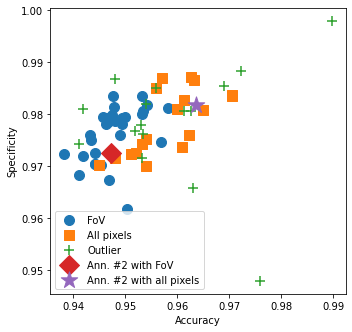

In [14]:
markers= ['o', 's', '+', 'x']
label_mapping= {'FoV': 'FoV', 'no FoV': 'All pixels', 'outlier': 'Outlier'}
plt.figure(figsize=(5, 5))
for i, c in enumerate(['FoV', 'no FoV', 'outlier']):
    plt.scatter(reduced[reduced['category_agg'] == c]['acc'], reduced[reduced['category_agg'] == c]['spec'], label=label_mapping[c], marker=markers[i], s=100)
plt.scatter([0.9473], [0.9725], label = 'Ann. #2 with FoV', marker='D', s=200)
plt.scatter([0.9636], [0.9818], label = 'Ann. #2 with all pixels', marker='*', s=300)
plt.xlabel('Accuracy')
plt.ylabel('Specificity')
plt.gca().set_aspect(1.0)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(figures_dir, 'aggregated.pdf'))
plt.show()

In [15]:
reduced[reduced['category_agg'] == 'excluded']

,key,flag,year,all_previous_processed,acc,sens,spec,digits,highest_ranked,second_human_observer,...,n_image_level,category,n_aggregated_scores,consistency_with_fov_mor,consistency_without_fov_mor,consistency_with_fov_rom,consistency_without_fov_rom,consistency_with_fov,consistency_without_fov,category_agg


## Saving the results

In [16]:
methods= pd.merge(methods.reset_index(drop=True), all[['key', 'category_agg']].reset_index(drop=True), on='key', how='left')

In [17]:
methods['category_final']= methods['category'].where(methods['category'].notnull(), methods['category_agg'])

In [18]:
methods.to_csv(aggregated_results_file, index=False)

In [19]:
np.sum(methods['invalid_ranking'] == 'yes')

91

In [20]:
methods

,key,flag,year,all_previous_processed,acc,sens,spec,digits,highest_ranked,second_human_observer,...,category,n_aggregated_scores,consistency_with_fov_mor,consistency_without_fov_mor,consistency_with_fov_rom,consistency_without_fov_rom,consistency_with_fov,consistency_without_fov,category_agg,category_final
0,adapa2020,primary,2020.0,yes,0.9450,0.6994,0.9811,4.0,thangaraj2017,no,...,FoV,1.0,1.000000,0.000000,0.000000,0.000000,True,False,FoV,FoV
1,alom2019,primary,2019.0,yes,0.9613,0.7661,0.9807,4.0,alom2019,no,...,NaN,5.0,0.600000,0.200000,0.400000,0.000000,False,False,outlier,outlier
2,anzalone2008,primary,2008.0,yes,0.9418,0.7286,0.9810,4.0,human,yes,...,NaN,1.0,0.000000,0.000000,0.000000,0.000000,False,False,outlier,outlier
3,azzopardi2014,primary,2014.0,yes,0.9442,0.7655,0.9704,4.0,ricci2007,no,...,NaN,3.0,0.666667,0.333333,0.333333,0.000000,True,False,FoV,FoV
4,barkana2017,primary,2017.0,yes,0.9502,0.7224,0.9840,4.0,wang2015,yes,...,outlier,4.0,1.000000,0.000000,0.500000,0.000000,True,False,FoV,outlier
5,brancati2018,primary,2018.0,yes,0.9490,0.7820,0.9760,3.0,frucci2017,yes,...,NaN,5.0,1.000000,0.400000,0.600000,0.200000,True,False,FoV,FoV
6,budai2013,primary,2013.0,yes,0.9570,0.6440,0.9870,3.0,budai2013,yes,...,NaN,1.0,0.000000,1.000000,0.000000,1.000000,False,True,no FoV,no FoV
7,chalakkal2017,primary,2017.0,yes,0.9518,0.7386,0.9769,4.0,lupascu2010,no,...,NaN,1.0,0.000000,0.000000,0.000000,0.000000,False,False,outlier,outlier
8,cheng2014,primary,2014.0,yes,0.9474,0.7252,0.9798,4.0,lupascu2010,yes,...,NaN,6.0,1.000000,0.000000,1.000000,0.000000,True,False,FoV,FoV
9,dai2015,primary,2015.0,yes,0.9418,0.7359,0.9720,4.0,dai2015,no,...,NaN,1.0,1.000000,0.000000,1.000000,0.000000,True,False,FoV,FoV
